In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import gzip
# import tensorflow as tf
import os
import torch
import shutil
import numpy as np
from scipy import ndimage
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import Softmax
from torch.nn.modules.activation import ReLU
# from tensorflow import keras
# from tensorflow.keras import layers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/mhrrs/.conda/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-21 18:36:09.875769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def unzip_files(folderpath):
    
    for file in os.listdir(folderpath):
        filepath = os.path.join(folderpath, file)
    
        with gzip.open(filepath, 'rb') as f_in:
            outpath = os.path.splitext(filepath)[0]
            print(f"outpath: {outpath} | filename: {file[:-3]}")
            outputfolder = os.path.join("./image_data/BSE_BET_DATA/nifti_files", file[:-3])
            with open(outputfolder, 'wb') as f_out:
                f_out.write(f_in.read())
        print(file)
    

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def display_scan(data):
    # Select the slice index you want to display or save (e.g., slice 20)
    slice_index = 100
    center = 32

    # Display the image data for the selected slice
    plt.imshow(data[:,:,center], cmap='gray')
    plt.axis('off')
    plt.show()

    # Save the image for the selected slice as JPEG
    plt.imsave(f'slice_{center}.jpg', data[:,center,:], cmap='gray')


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    
    return volume

# Break up the Nifti_files folder into two different folders: recognizable and other
Recognizable will be known as non_strip, and other will be known as stripped

NOTE: Due to issues with whatever computer you are using, you may need to physically move the folders that contain the images into 3 folders named: A, B, and C within a folder name image_folder. This will allow you to skip the following cell and carry on with the rest of the program.

In [ ]:
nifti_folder = "./image_data/BSE_BET_DATA/nifti_files"

csv = np.loadtxt("./image_data/BSE_BET_DATA/labels.csv", delimiter=",", dtype=str)

recognizable = []
for item in csv:
    if item[1] == "Yes":
        recognizable.append(item[0])

outputfolder = "./image_data/BSE_BET_DATA/recognizable_features"
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
    
nonfolder = "./image_data/BSE_BET_DATA/non_features"
if not os.path.exists(nonfolder):
    os.makedirs(nonfolder)

# for file in os.listdir(nifti_folder):
#     if file in recognizable:
#         filepath = os.path.join(nifti_folder, file)
#         outputpath = os.path.join(outputfolder, file)
#         with open(filepath, 'rb') as f_in, open(outputpath, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)
    
#     else:
#         filepath = os.path.join(nifti_folder, file)
#         nonpath = os.path.join(nonfolder, file)
#         with open(filepath, 'rb') as f_in, open(nonpath, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)


In [ ]:
A_folder = os.listdir("./image_folder/A") # recognizable/ no data loss
B_folder = os.listdir("./image_folder/B") #non-recognizable/ data loss
C_folder = os.listdir("./image_folder/C") #non-recognizable/ no data loss

A_set = np.array([process_scan(os.path.join("./image_folder/A",path)) for path in A_folder[:350]])
print("A set done.")
B_set = np.array([process_scan(os.path.join("./image_folder/B",path)) for path in B_folder[:350]])
print("B set done.")
C_set = np.array([process_scan(os.path.join("./image_folder/C",path)) for path in C_folder[:350]])
print("C set done.")

In [154]:
# 2 == A_set and 1 == B_set and 0 == C_set
A_set_labels = np.array([0 for _ in range(len(A_set))])
B_set_labels = np.array([1 for _ in range(len(B_set))])
C_set_labels = np.array([2 for _ in range(len(C_set))])

x_train = np.concatenate((A_set[:250], B_set[:250], C_set[:250]),axis=0)
y_train = np.concatenate((A_set_labels[:250], B_set_labels[:250], C_set_labels[:250]),axis=0)
x_val = np.concatenate((A_set[250:], B_set[250:], C_set[250:]),axis=0)
y_val = np.concatenate((A_set_labels[250:], B_set_labels[250:], C_set_labels[250:]),axis=0)

print(f"x train: {x_train.shape} | x val: {x_val.shape}")
print(f"y train: {y_train.shape} | y val: {y_val.shape}")

x train: (750, 128, 128, 64) | x val: (300, 128, 128, 64)
y train: (750,) | y val: (300,)


In [155]:
# turn x_train and y_train into a dataloader
x_train = torch.tensor(x_train, dtype=torch.float32)
x_train = np.transpose(x_train, (0,3,1,2))
x_train = x_train.unsqueeze(1)
print(x_train.shape)
y_train = torch.tensor(y_train, dtype=torch.long)
train_ds = TensorDataset(x_train, y_train)

# turn x_val and y_val into a dataloader
x_val = torch.tensor(x_val, dtype=torch.float32)
x_val = np.transpose(x_val, (0,3,1,2))
x_val = x_val.unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.long)
val_ds = TensorDataset(x_val, y_val)

torch.Size([750, 1, 64, 128, 128])


In [4]:
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True) #creates shape: (2, 64, 128, 128)
torch.save(train_dl, 'train_dl_ext_v2.pth')
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True)
torch.save(val_dl, 'val_dl_ext_v2.pth')
print("dl saved.")

NameError: name 'train_ds' is not defined

In [3]:
# load the saved dataloader
# train_dataloader = DataLoader(my_dataset)
# train_dataloader.load_state_dict(torch.load('train_dl.pth'))

train_dl = torch.load('train_dl_ext_v2.pth')
val_dl = torch.load('val_dl_ext_v2.pth')
print(len(train_dl), len(val_dl))

375 150


# 3D PyTorch Model

In [4]:
import torch
import torch.nn as nn

class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(2)
        
        self.fc1 = nn.Linear(128 * 2 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 128)
        
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(.8)
        
        self.fc3 = nn.Linear(128, 3)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 2 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return self.softmax(x)

# Create the network instance
simple_3d_cnn = Simple3DCNN()

# Create a random input tensor of size (2, 1, 5, 128, 128)
input_tensor = torch.randn(2, 1, 64, 128, 128)

# Forward pass through the network
output = simple_3d_cnn(input_tensor)
print(output)
print()
# print(output[0,1])
print()
pred = torch.max(output,1)
print(pred)
print()
print("Output shape:", output.shape)


tensor([[0.3355, 0.3065, 0.3580],
        [0.3335, 0.3087, 0.3578]], grad_fn=<SoftmaxBackward0>)


torch.return_types.max(
values=tensor([0.3580, 0.3578], grad_fn=<MaxBackward0>),
indices=tensor([2, 2]))

Output shape: torch.Size([2, 3])


In [5]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv3d, nn.BatchNorm2d)):
            nn.init.xavier_uniform_(m.weight.data)

In [6]:
def amp_fit(model, n_epochs):
    # initialize the weights of the model
    init_weights(model)
    
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.0001)
    scaler = torch.cuda.amp.GradScaler()
    total_loss = 0
    loss_items = []
    
    # linear learning rate decay setup
    n_t_steps = len(train_dl) * n_epochs
    n_w_steps = .1 * n_t_steps
    scheduler = get_linear_schedule_with_warmup(optim, n_w_steps, n_t_steps)
    
    model.train()
    for epoch in range(n_epochs):
        
        for step, (inputs, labels) in enumerate(train_dl): #inputs.shape =(2,5,128,128)
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.cuda.amp.autocast():
                output = model(inputs)
                loss = criterion(output, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            scheduler.step()
            
            if (step+1)%len(train_dl) == 0:
                loss_items.append(loss.item())
                print(f"epoch: {epoch+1} | step: {step+1}/{len(train_dl)} | loss: {loss.item():4f}")
                
    return loss_items

In [7]:
model = Simple3DCNN()
model.to(device)
model_loss = amp_fit(model,20)

epoch: 1 | step: 375/375 | loss: 0.862117
epoch: 2 | step: 375/375 | loss: 0.880895
epoch: 3 | step: 375/375 | loss: 0.870207
epoch: 4 | step: 375/375 | loss: 0.895141
epoch: 5 | step: 375/375 | loss: 0.870365
epoch: 6 | step: 375/375 | loss: 1.131137
epoch: 7 | step: 375/375 | loss: 0.805357
epoch: 8 | step: 375/375 | loss: 0.837643
epoch: 9 | step: 375/375 | loss: 0.997870
epoch: 10 | step: 375/375 | loss: 0.999548
epoch: 11 | step: 375/375 | loss: 0.890131
epoch: 12 | step: 375/375 | loss: 0.751628
epoch: 13 | step: 375/375 | loss: 0.729746
epoch: 14 | step: 375/375 | loss: 0.888280
epoch: 15 | step: 375/375 | loss: 0.860480
epoch: 16 | step: 375/375 | loss: 0.959564
epoch: 17 | step: 375/375 | loss: 0.997441
epoch: 18 | step: 375/375 | loss: 0.691168
epoch: 19 | step: 375/375 | loss: 1.017558
epoch: 20 | step: 375/375 | loss: 0.755588


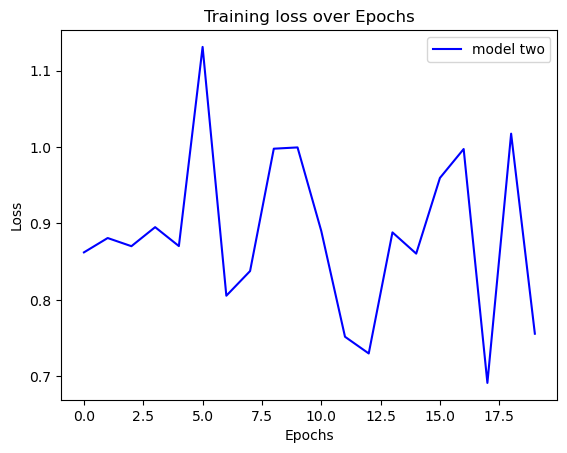

In [8]:
plt.plot(model_loss, color="blue", label="model two")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss over Epochs')
plt.legend()
plt.show()

In [9]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data in val_dl:
        inp, val_outp = data
        inp, val_outp = inp.cuda(), val_outp.cuda()
        out = model(inp)
        # shape (batch, 3)
        
        # print(out)
        _, pred = torch.max(out.data,1)
        print(out.data)
        
        total += val_outp.size(0)
        print(f"predicted | actual: {pred} | {val_outp}")
        correct += (pred == val_outp).sum().item()
        
print(f'Accuracy: {100*(correct/total)}%')

tensor([[0.0740, 0.7281, 0.1979],
        [0.0701, 0.3830, 0.5469]], device='cuda:0')
predicted | actual: tensor([1, 2], device='cuda:0') | tensor([1, 2], device='cuda:0')
tensor([[0.2353, 0.6569, 0.1079],
        [0.0646, 0.6800, 0.2554]], device='cuda:0')
predicted | actual: tensor([1, 1], device='cuda:0') | tensor([0, 1], device='cuda:0')
tensor([[0.5986, 0.3503, 0.0511],
        [0.0811, 0.4022, 0.5167]], device='cuda:0')
predicted | actual: tensor([0, 2], device='cuda:0') | tensor([0, 2], device='cuda:0')
tensor([[0.0721, 0.7651, 0.1627],
        [0.0701, 0.3828, 0.5471]], device='cuda:0')
predicted | actual: tensor([1, 2], device='cuda:0') | tensor([1, 2], device='cuda:0')
tensor([[0.0641, 0.8061, 0.1298],
        [0.5972, 0.3456, 0.0572]], device='cuda:0')
predicted | actual: tensor([1, 0], device='cuda:0') | tensor([1, 0], device='cuda:0')
tensor([[0.0750, 0.5178, 0.4072],
        [0.0701, 0.3830, 0.5470]], device='cuda:0')
predicted | actual: tensor([1, 2], device='cuda:0') | 

In [21]:
torch.save(model, "modelv3.pth")